In [3]:
# Unzipping the Data
!unzip /content/drive/MyDrive/DS_DATA/skin_Care.zip -d /content/data_file

Archive:  /content/drive/MyDrive/DS_DATA/skin_Care.zip
  inflating: /content/data_file/product_info.csv  
  inflating: /content/data_file/reviews_0_250.csv  
  inflating: /content/data_file/reviews_1000_1500.csv  
  inflating: /content/data_file/reviews_1500_end.csv  
  inflating: /content/data_file/reviews_250_500.csv  
  inflating: /content/data_file/reviews_500_750.csv  
  inflating: /content/data_file/reviews_750_1000.csv  


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import warnings
import ast
import re
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings(action='ignore')

### Reading Datas

In [5]:
product_data=pd.read_csv("/content/data_file/product_info.csv")
review_data1=pd.read_csv("/content/data_file/reviews_0_250.csv")
review_data2=pd.read_csv("/content/data_file/reviews_250_500.csv")

### Display Data

In [13]:
product_df=pd.DataFrame(product_data)
df_clean=product_df.copy()

In [14]:
product_df.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [15]:
# Shape of DataFrame
product_df.shape

(8494, 27)

In [16]:
#Columns of Data
product_df.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

In [17]:
#Datatype of columns
product_df.dtypes.reset_index().rename(columns={'index':'Column',0:'Datatype'})

,Column,Datatype
0,product_id,object
1,product_name,object
2,brand_id,int64
3,brand_name,object
4,loves_count,int64
5,rating,float64
6,reviews,float64
7,size,object
8,variation_type,object
9,variation_value,object


### Feature Engineering

In [18]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

Converting Size column in to categorical column

In [19]:
# Convert numeric values into custom-defined bins
def size_mapping(value):
  if  value< 11.0:
        return '1-10 ML'
  elif value >=11.0 and value<31.0:
      return '11-30 ML'
  elif value >=31.0 and value<51.0:
      return '31-50 ML'
  elif value >=50.0 and value<76.0:
      return '50-75 ML'
  elif value >=76.0 and value<101.0:
      return '75-100 ML'
  elif value >=101.0 and value<126.0:
      return '100-125 ML'
  elif value >=126.0 and value<175.0:
      return '125-175 ML'
  else:
      return 'Above 175 ML'

In [20]:
df_clean['size']=df_clean['size'].apply(lambda x: re.sub(r'/.*', '', x).replace("oz","").strip() if pd.notnull(x) else x).apply(lambda x: x.replace("fl","").strip() if pd.notnull(x) else x).apply(lambda x: x.replace("ml","").strip() if pd.notnull(x) else x).apply(lambda x: size_mapping(round(float(x)*29.573,2)) if pd.notnull(x) and is_float(x) else x)

In [21]:
#Drop Unwanted columns
df_clean.drop(['ingredients','variation_type','variation_value','variation_desc'],inplace=True,axis=1)

In [22]:
# df_clean=df_clean.melt(id_vars=['product_id','product_name'],value_vars=range(10))
# df_clean

### Null value count of column and Visualization

In [23]:
df_null=(df_clean.isnull().mean()*100).reset_index().rename(columns={'index':'Column',0:'Percentage'})
df_null

,Column,Percentage
0,product_id,0.000000
1,product_name,0.000000
2,brand_id,0.000000
3,brand_name,0.000000
4,loves_count,0.000000
5,rating,3.272899
6,reviews,3.272899
7,size,19.201789
8,price_usd,0.000000
9,value_price_usd,94.690370


<Axes: >

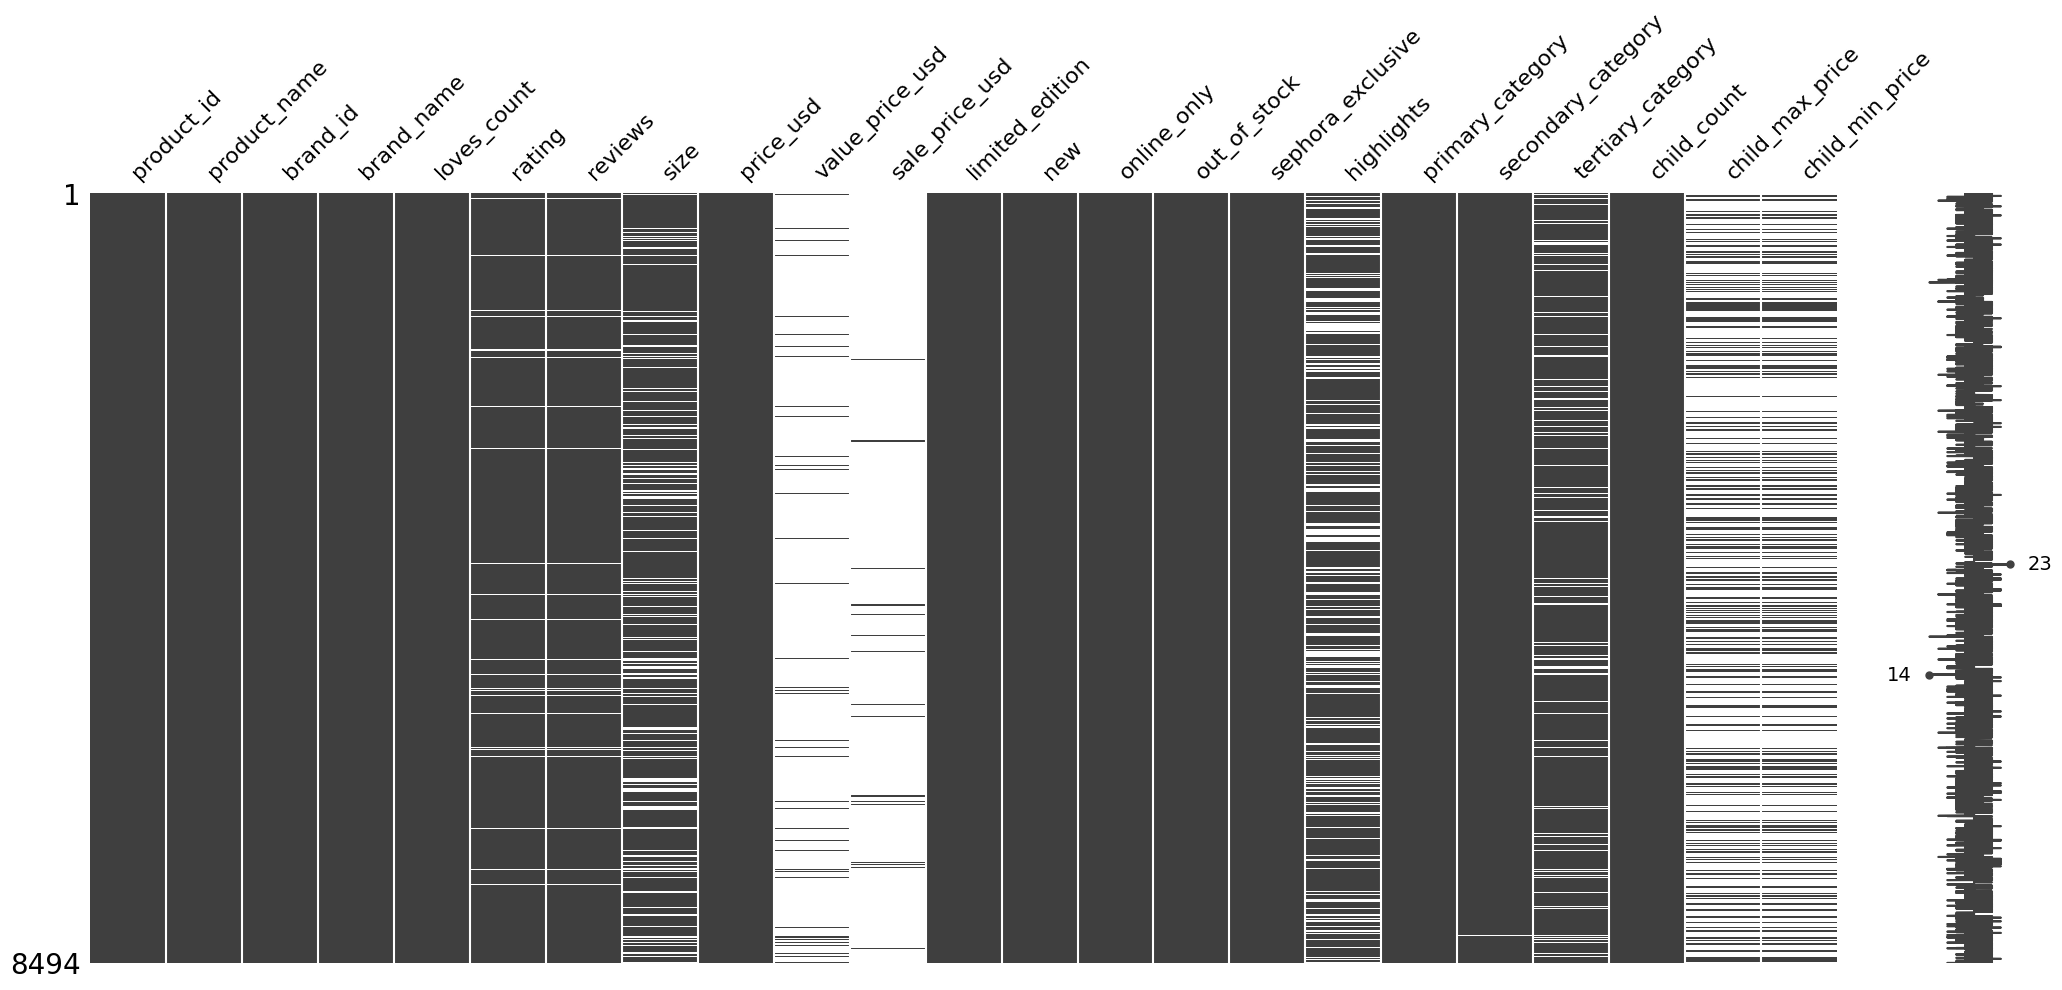

In [24]:
msno.matrix(df_clean)

Dropping Null value column above 65% of missing values

In [25]:
drop_col=df_null.loc[df_null['Percentage']>=65]['Column'].values
df_clean.drop(drop_col,axis=1,inplace=True)

In [26]:
impute_col=df_null.loc[(df_null['Percentage']>0)&(df_null['Percentage']<=65)]['Column'].values
impute_col

array(['rating', 'reviews', 'size', 'highlights', 'secondary_category',
       'tertiary_category'], dtype=object)

In [27]:
numeric_col=df_clean[impute_col].select_dtypes(include=['number']).columns.values
categoric_col=df_clean[impute_col].select_dtypes(exclude=['number']).columns.values

In [28]:
categoric_col

array(['size', 'highlights', 'secondary_category', 'tertiary_category'],
      dtype=object)

In [29]:
numeric_col

array(['rating', 'reviews'], dtype=object)

In [30]:
prod_imputat=df_clean.copy()

In [31]:
dt_impu=prod_imputat.drop(['product_name','brand_name','product_id','brand_id','highlights','tertiary_category','child_count'],axis=1)

In [32]:
dt_impu.head()

,loves_count,rating,reviews,size,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,primary_category,secondary_category
0,6320,3.6364,11.0,NaN,35.0,0,0,1,0,0,Fragrance,Value & Gift Sets
1,3827,4.1538,13.0,75-100 ML,195.0,0,0,1,0,0,Fragrance,Women
2,3253,4.2500,16.0,75-100 ML,195.0,0,0,1,0,0,Fragrance,Women
3,3018,4.4762,21.0,75-100 ML,195.0,0,0,1,0,0,Fragrance,Women
4,2691,3.2308,13.0,75-100 ML,195.0,0,0,1,0,0,Fragrance,Women


In [33]:
dt_impu.shape

(8494, 12)

###Data Cleaning

#### Imputing Null values using KNN Imputer

In [34]:
# Initialize the KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=3)
df=dt_impu.drop(['size','primary_category','secondary_category'],axis=1)
df_abc=dt_impu[['size','primary_category','secondary_category']]
# Perform k-NN imputation
imputed_data = imputer.fit_transform(df)

# Convert the imputed data array back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=df.columns)
df_imputed=pd.concat([df_abc,imputed_df],axis=1)
df_imputed.head()

,size,primary_category,secondary_category,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive
0,NaN,Fragrance,Value & Gift Sets,6320.0,3.6364,11.0,35.0,0.0,0.0,1.0,0.0,0.0
1,75-100 ML,Fragrance,Women,3827.0,4.1538,13.0,195.0,0.0,0.0,1.0,0.0,0.0
2,75-100 ML,Fragrance,Women,3253.0,4.2500,16.0,195.0,0.0,0.0,1.0,0.0,0.0
3,75-100 ML,Fragrance,Women,3018.0,4.4762,21.0,195.0,0.0,0.0,1.0,0.0,0.0
4,75-100 ML,Fragrance,Women,2691.0,3.2308,13.0,195.0,0.0,0.0,1.0,0.0,0.0


In [35]:
df_imputed.shape

(8494, 12)

In [36]:
index_analy=df_imputed.dropna(subset=['secondary_category']).index

In [37]:
df_imputed = df_imputed.dropna(subset=['secondary_category']).reset_index()
df_imputed.drop(['index'],axis=1,inplace=True)
df_imputed.tail()

,size,primary_category,secondary_category,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive
8481,NaN,Makeup,Eye,2790.0,4.428600,7.000000,150.0,0.0,0.0,0.0,0.0,0.0
8482,50-75 ML,Fragrance,Men,2319.0,4.636700,556.000000,106.0,0.0,0.0,0.0,0.0,0.0
8483,NaN,Fragrance,Value & Gift Sets,1475.0,5.000000,2.000000,134.0,1.0,1.0,1.0,1.0,0.0
8484,NaN,Fragrance,Value & Gift Sets,840.0,3.916667,4.666667,167.0,1.0,1.0,1.0,0.0,0.0
8485,1-10 ML,Makeup,Lip,193.0,4.771033,38.000000,50.0,0.0,1.0,1.0,0.0,1.0


In [38]:
df_null=(df_imputed.isnull().mean()*100).reset_index().rename(columns={'index':'Column',0:'Percentage'})
df_null

,Column,Percentage
0,size,19.172755
1,primary_category,0.000000
2,secondary_category,0.000000
3,loves_count,0.000000
4,rating,0.000000
5,reviews,0.000000
6,price_usd,0.000000
7,limited_edition,0.000000
8,new,0.000000
9,online_only,0.000000


In [39]:
demo=df_imputed.drop(['primary_category','secondary_category'],axis=1)

#### Encoding Categorical columns using Decision Tree Imputer

In [40]:
# Perform one-hot encoding
encoder = OneHotEncoder()
encoder1 = OneHotEncoder()


encoded_data = encoder.fit_transform(df_imputed[['primary_category']])
encoded_data1 = encoder1.fit_transform(df_imputed[['secondary_category']])

# Create a DataFrame with the original categorical values
encoded_df1 = pd.DataFrame(encoded_data.toarray(),columns=list(encoder.categories_[0]))
encoded_df2 = pd.DataFrame(encoded_data1.toarray(),columns=list(encoder1.categories_[0]))

df_encoded = pd.concat([encoded_df1,encoded_df2], axis=1)

df_encoded = pd.concat([demo,df_encoded], axis=1)
df_encoded.tail()

,size,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,...,Shampoo & Conditioner,Shaving,Shop by Concern,Skincare,Sunscreen,Tools,Treatments,Value & Gift Sets,Wellness,Women
8481,NaN,2790.0,4.428600,7.000000,150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8482,50-75 ML,2319.0,4.636700,556.000000,106.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8483,NaN,1475.0,5.000000,2.000000,134.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8484,NaN,840.0,3.916667,4.666667,167.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8485,1-10 ML,193.0,4.771033,38.000000,50.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
colum=df_encoded.columns.to_list()
colum.remove('size')

#### Imputing Null values using Decision Tree Imputer

In [42]:

# Separate complete and incomplete data
complete_data = df_encoded.dropna()
incomplete_data = df_encoded[df_encoded.isna().any(axis=1)]

# Prepare the training data
X_train = complete_data[colum]
y_train = complete_data['size']

# Train a decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [43]:
X_test = incomplete_data[colum]
y_pred = tree.predict(X_test)

In [44]:

# Fill in the missing values
df_encoded.loc[incomplete_data.index, 'size'] = y_pred

In [45]:
df_encoded.head()

,size,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,...,Shampoo & Conditioner,Shaving,Shop by Concern,Skincare,Sunscreen,Tools,Treatments,Value & Gift Sets,Wellness,Women
0,125-175 ML,6320.0,3.6364,11.0,35.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,75-100 ML,3827.0,4.1538,13.0,195.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,75-100 ML,3253.0,4.2500,16.0,195.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,75-100 ML,3018.0,4.4762,21.0,195.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,75-100 ML,2691.0,3.2308,13.0,195.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
# Convert the one-hot encoded data back to its original form
decoded_data = encoder.inverse_transform(encoded_data).flatten()
decoded_data1 = encoder1.inverse_transform(encoded_data1).flatten()

# Create a DataFrame with the original categorical values
decoded_df1 = pd.DataFrame(decoded_data, columns=['primary_category'])
decoded_df2 = pd.DataFrame(decoded_data1, columns=['secondary_category'])

df_decoded = pd.concat([decoded_df1,decoded_df2], axis=1)
df_decoded.head()

,primary_category,secondary_category
0,Fragrance,Value & Gift Sets
1,Fragrance,Women
2,Fragrance,Women
3,Fragrance,Women
4,Fragrance,Women


In [47]:
df1=df_encoded.drop(list(encoder.categories_[0])+list(encoder1.categories_[0]),axis=1)
df_cleaned_data=pd.concat([df1,df_decoded],axis=1)

### Cleaned Data

In [48]:
df_cleaned_data.head()

,size,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,primary_category,secondary_category
0,125-175 ML,6320.0,3.6364,11.0,35.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Value & Gift Sets
1,75-100 ML,3827.0,4.1538,13.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
2,75-100 ML,3253.0,4.2500,16.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
3,75-100 ML,3018.0,4.4762,21.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
4,75-100 ML,2691.0,3.2308,13.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women


In [49]:
df_null=(df_cleaned_data.isnull().mean()*100).reset_index().rename(columns={'index':'Column',0:'Percentage'})
df_null

,Column,Percentage
0,size,0.0
1,loves_count,0.0
2,rating,0.0
3,reviews,0.0
4,price_usd,0.0
5,limited_edition,0.0
6,new,0.0
7,online_only,0.0
8,out_of_stock,0.0
9,sephora_exclusive,0.0


#Exploratory data Analysis

In [50]:
import plotly.express as px


## Numerical Analysis

### Univariate Analysis

In [51]:
numeric_col

array(['rating', 'reviews'], dtype=object)

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff


In [53]:
group_labels =['rating']
fig = ff.create_distplot([df_cleaned_data['rating']],group_labels,
                         bin_size=.1, show_rug=True)

# Add title
fig.update_layout(title_text='Numerical Distribution of Rating',xaxis=dict(titlefont = dict(size=15),tickfont = dict(size=14)),yaxis=dict(titlefont = dict(size=15),tickfont = dict(size=13),
        showgrid=False,
        showticklabels=True),plot_bgcolor='black')
fig.update_traces(textfont=dict(size=15,color='White'))
fig.show()

In [54]:
group_labels =['reviews']
fig = ff.create_distplot([df_cleaned_data['reviews']],group_labels,
                         bin_size=.2, show_rug=False)

# Add title
fig.update_layout(title_text='Numerical Distribution of Reviews',xaxis=dict(titlefont = dict(size=15),tickfont = dict(size=14)),yaxis=dict(titlefont = dict(size=15),tickfont = dict(size=13),
        showgrid=False,
        showticklabels=True),plot_bgcolor='black')
# fig.update_traces(textfont=dict(size=15,color='White'))
fig.show()

### Bivariate Analysis

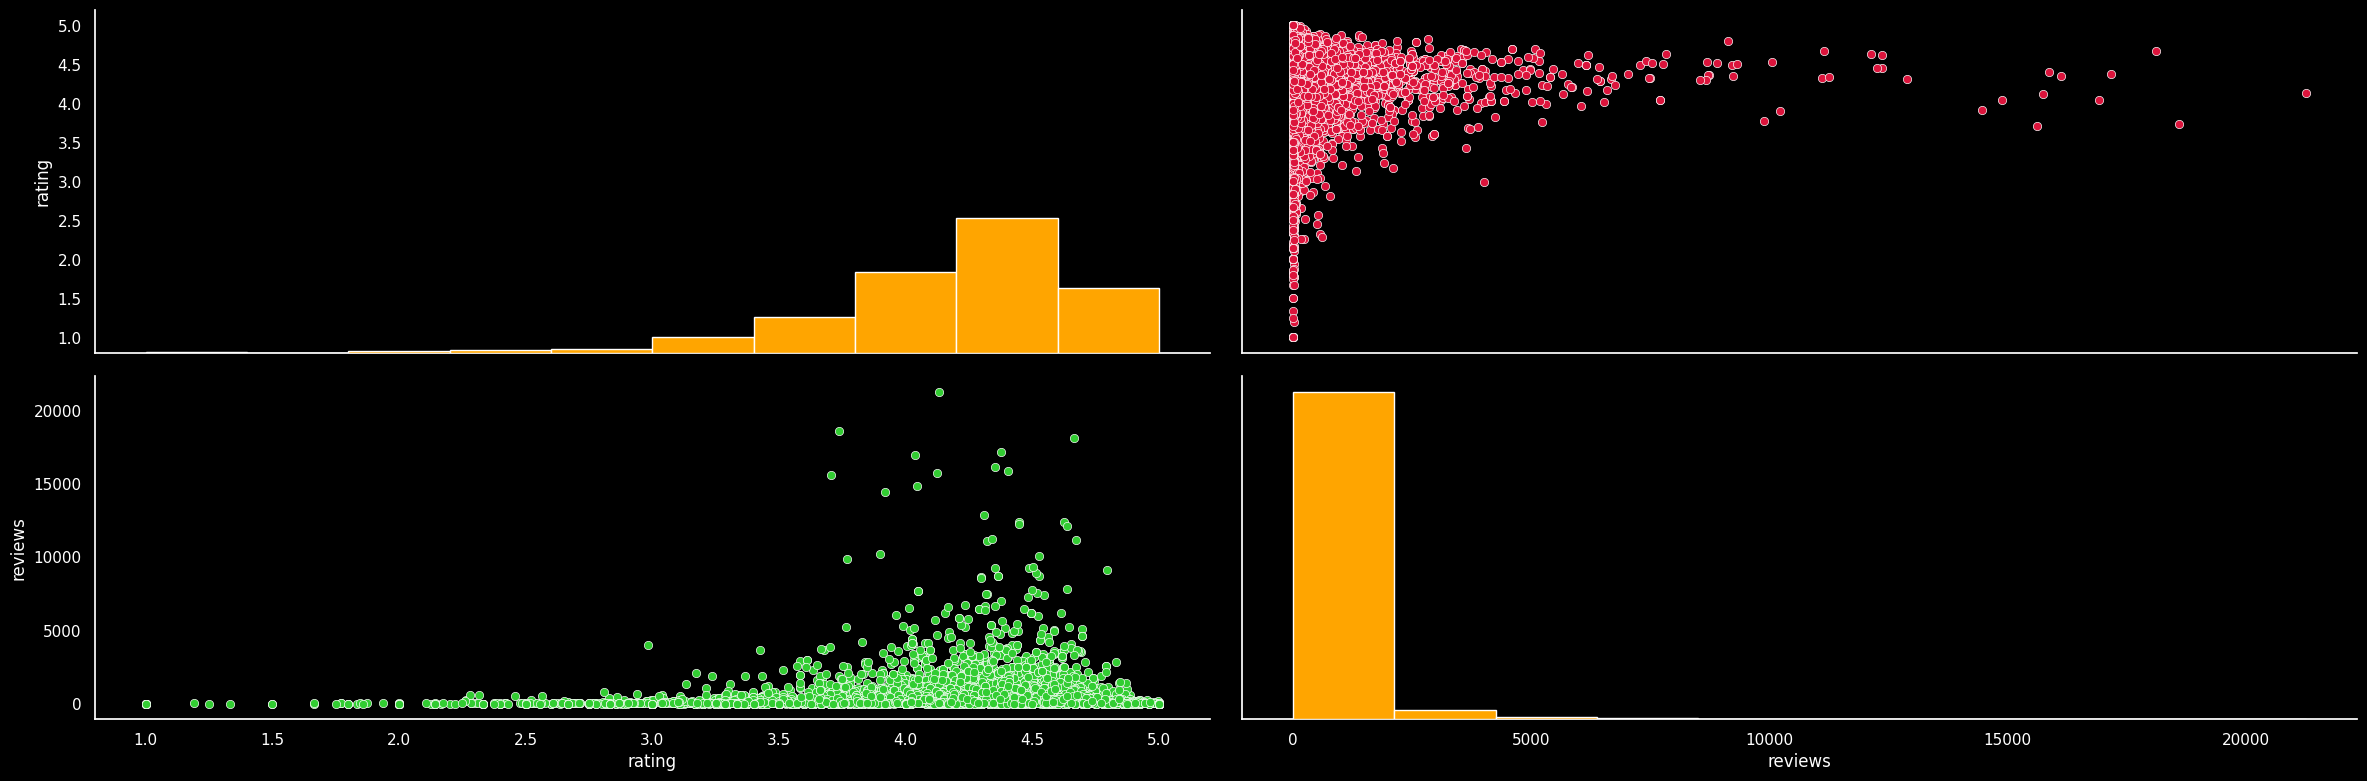

In [55]:
#Plotting a pair plot for bivariate analysis
sns.set_theme('notebook', style='dark')
plt.style.use("dark_background")

g = sns.PairGrid(df_cleaned_data,vars=numeric_col,aspect=3,height=4)
#setting color
g.map_upper(sns.scatterplot, color='crimson')
g.map_lower(sns.scatterplot, color='limegreen')
g.map_diag(plt.hist, color='orange')
#show figure
plt.show()

## Outlier Visualization using Boxplot

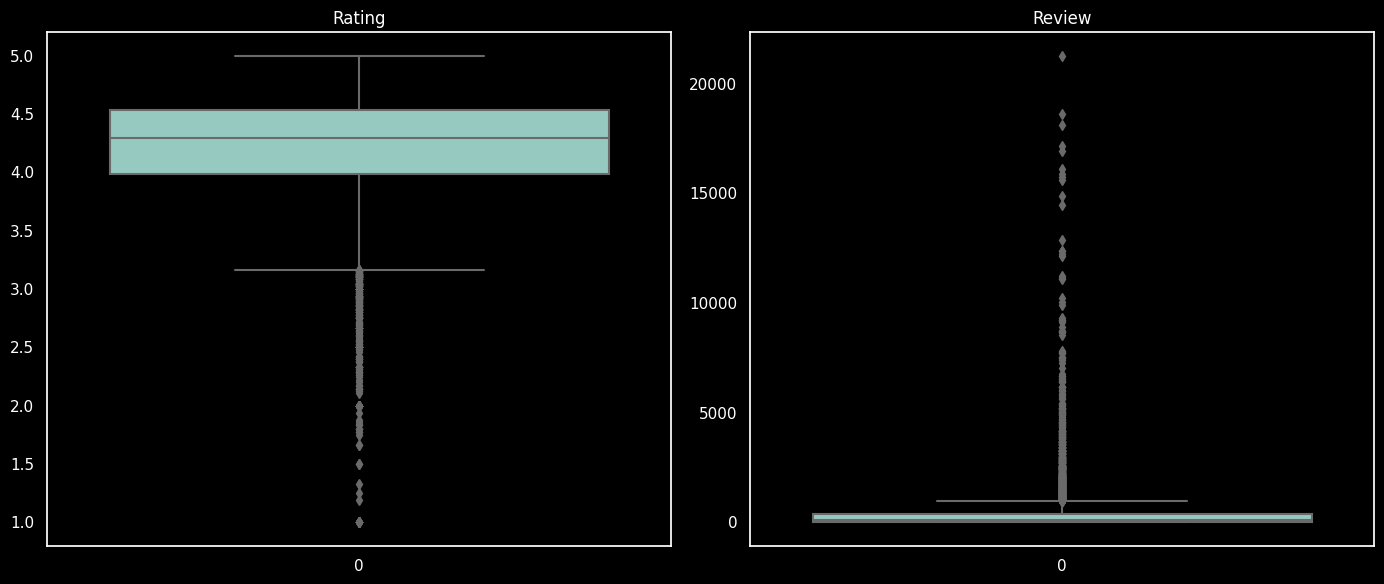

In [56]:

# Create two separate plots
plt.style.use("dark_background")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1 on the first axis
sns.boxplot(data=df_cleaned_data['rating'], ax=ax1)
ax1.set_title('Rating')

# Plot 2 on the second axis
sns.boxplot(data=df_cleaned_data['reviews'], ax=ax2)
ax2.set_title('Review')

# Adjust spacing between the subplots
plt.tight_layout()

# Display the figure
plt.show()


## Outlier Removal

In [57]:
df_cleaned_data=df_cleaned_data.loc[df_cleaned_data['rating']>=2.5]
df_cleaned_data=df_cleaned_data.loc[df_cleaned_data['reviews']<=5000]

In [58]:
produ_rec=product_df.loc[index_analy,['product_name','brand_name','brand_id']].reset_index().drop('index',axis=1)

In [59]:
df_analys = pd.merge(produ_rec, df_cleaned_data, left_index=True, right_index=True)

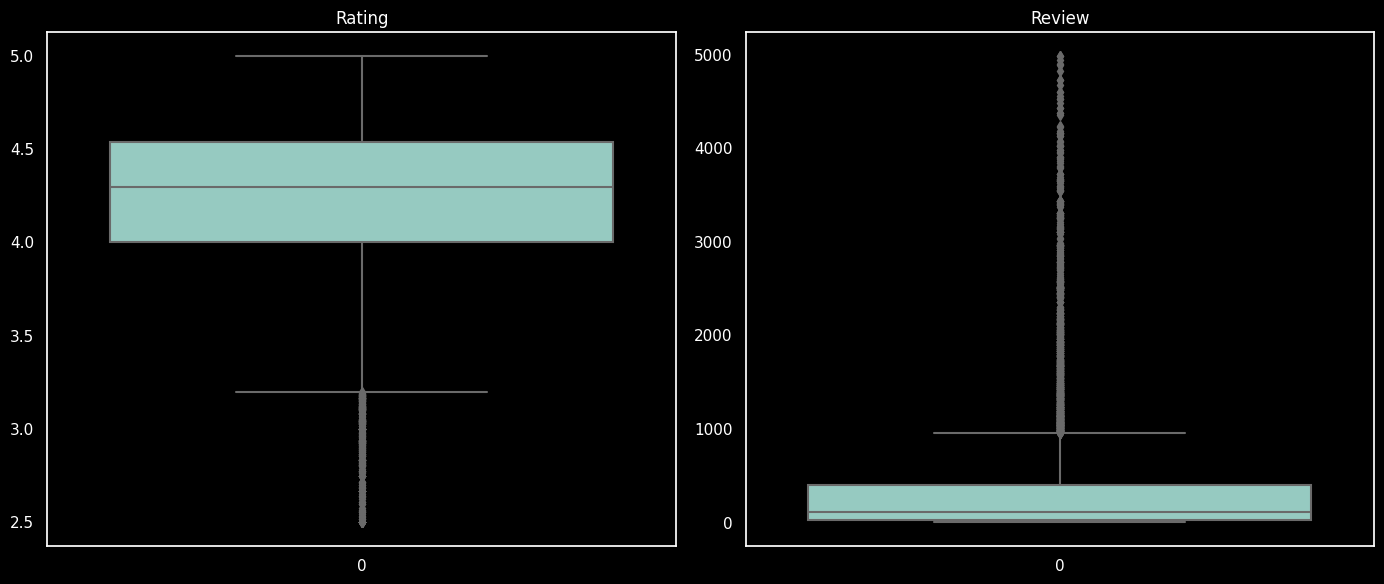

In [60]:

# Create two separate plots
plt.style.use("dark_background")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1 on the first axis
sns.boxplot(data=df_analys['rating'], ax=ax1)
ax1.set_title('Rating')

# Plot 2 on the second axis
sns.boxplot(data=df_analys['reviews'], ax=ax2)
ax2.set_title('Review')

# Adjust spacing between the subplots
plt.tight_layout()

# Display the figure
plt.show()


In [61]:
# df_analys=pd.concat([produ_rec,df_cleaned_data],axis=1)
df_analys.head()

,product_name,brand_name,brand_id,size,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,primary_category,secondary_category
0,Fragrance Discovery Set,19-69,6342,125-175 ML,6320.0,3.6364,11.0,35.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Value & Gift Sets
1,La Habana Eau de Parfum,19-69,6342,75-100 ML,3827.0,4.1538,13.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
2,Rainbow Bar Eau de Parfum,19-69,6342,75-100 ML,3253.0,4.2500,16.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
3,Kasbah Eau de Parfum,19-69,6342,75-100 ML,3018.0,4.4762,21.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women
4,Purple Haze Eau de Parfum,19-69,6342,75-100 ML,2691.0,3.2308,13.0,195.0,0.0,0.0,1.0,0.0,0.0,Fragrance,Women


In [62]:
df_analys.shape

(8321, 15)

<Axes: >

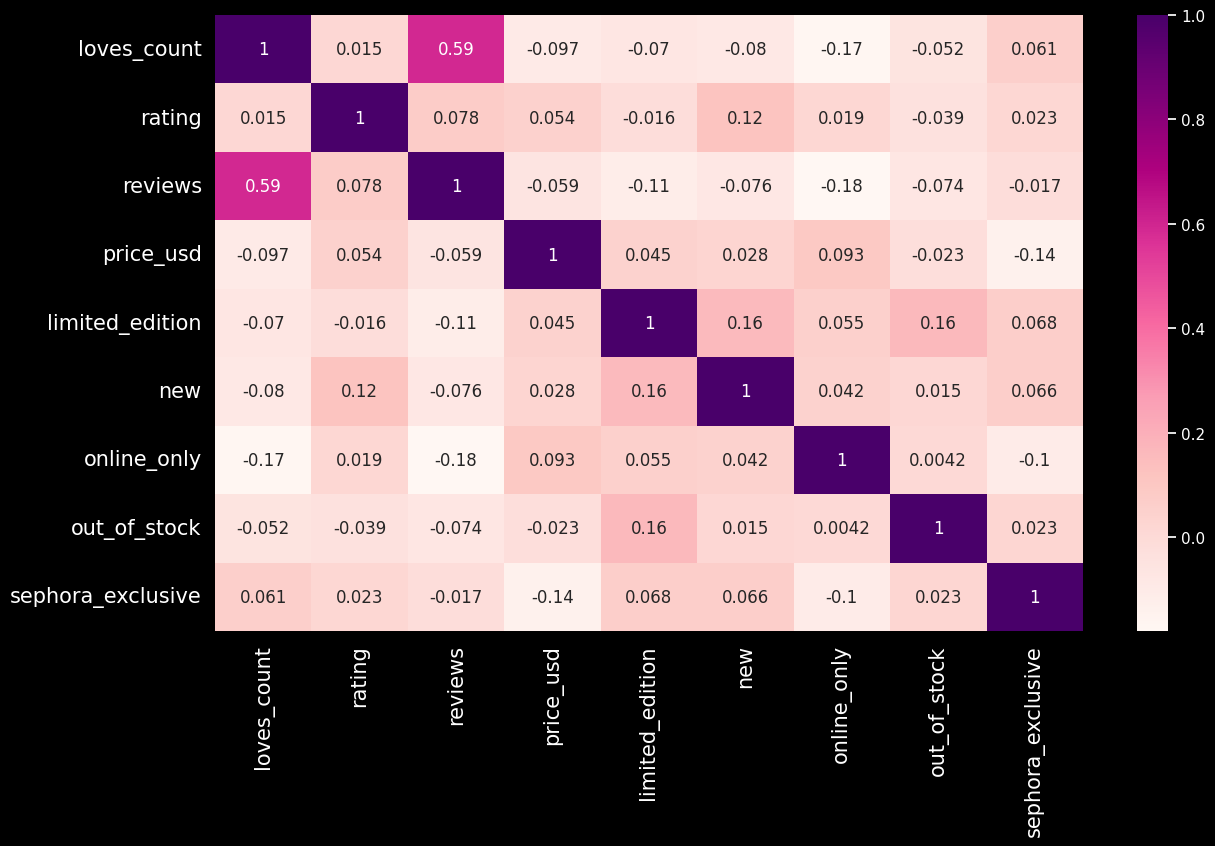

In [ ]:
#setting the figure size and fontsize
plt.figure(figsize=(14,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#visualzing the corelation between all numeric features
sns.heatmap(df_analys.drop('brand_id',axis=1).corr(),annot=True,cmap='RdPu')

## **Asking Question to Data and getting Insighs from Data**

### ***1. Which brand is popular among user and loves count based on reviews and ratings?***

In [ ]:
abc=df_analys.groupby('brand_name')[['loves_count','reviews']].sum().reset_index().sort_values(['loves_count'],ascending=False).head(25)

In [ ]:
eg=df_analys[df_analys['brand_name'].isin(list(abc['brand_name'].values))]
eg1=eg.groupby('brand_name')['rating'].mean().reset_index()
merged_efg1 = pd.merge(abc, eg1, on='brand_name')


In [ ]:
#plotting bubble chart for all reviews in neighborhood area
fig = px.scatter(merged_efg1, x="rating", y="reviews",
	         size="loves_count", color="brand_name",text='loves_count',
                 hover_name="rating", log_x=True, size_max=80,opacity=.75,color_discrete_sequence= px.colors.qualitative.Alphabet,labels={
                     "rating": "Average Ratings",
                     "reviews": "Total Reviews",
                     "brand_name": "Top Brand Name"})
#Updating traces and layout to beautify the plot and setting the font size
#fig.update_traces(textfont=dict(size=10,color='White'))
fig.update_traces(textfont=dict(size=10,color='White'))
fig.update_layout(title={'text': 'Top 25 Popular brand based on User reviews,ratings and Loves count',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},autosize=False,yaxis=dict(
        showgrid=False),xaxis=dict(
        showgrid=False),
    width=1400,
    height=600,plot_bgcolor='black')
#show figure
fig.show()

**Observations:**

This plot indicates Bubble chart where **X** and **Y** has Numerical columns and **Size** of bubble denoted by Numeric columns



*   Brand Name "Sephora Collection" has large Loves count around 11 Million thats why it has large bubble size compare to others and its average rating 4.12, Total reviews are 120.17K
*   Second largest bubble size of brand name is Charlotte Tilbury with loves count around 7.7 Million and its average rating 3.98, Total reviews are 33.3K
*   Yves Saint Laurent has highest average rating of 4.47 with reviews of 41.2k and loves count has 2.4 Million



### ***2. What is the total worth of price value for Each Brand respective to their Category?***

In [ ]:
abc1=df_analys.groupby(['brand_name','primary_category','secondary_category'])['price_usd'].sum().reset_index().sort_values(['price_usd'],ascending=False).head(30)


In [ ]:
fig = px.sunburst(abc1, path=['brand_name','primary_category','secondary_category'], values='price_usd',color_discrete_sequence= px.colors.sequential.Plasma)
fig.update_layout(title={'text': 'Total worth of price value for Top 30 Brand respective to their Category',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},autosize=False,yaxis=dict(
        showgrid=False),xaxis=dict(
        showgrid=False),
    width=1400,
    height=600,paper_bgcolor="black",title_font_color="White")
fig.show()

**Observations:**

*   Brand Name "Tom Ford" has high worth of share among other top brand with price of all products around 10,592 USD and it has 'Fragrance' has Primary category and 'Women' has Secondary Category.

*   Second Top most brand is Jo Malone London with share of price 7024 USD. It primary category is alone Fragrance and Seconday category has' Women' and 'Candles & Home Scents' which shared among 5102 USD and 1922 USD of total 7024 USD





### ***3. Which size is most preferred by user based on primary category?***

In [ ]:
sa=df_analys.groupby(['size','primary_category'])['loves_count'].count().reset_index().sort_values(by='loves_count',ascending=False).head(23)

In [ ]:

fig = px.bar(x='size',y='loves_count',data_frame=sa,color='primary_category',text='loves_count',barmode='group',opacity=.7,color_discrete_map={
                "Makeup": "coral",
                "Skincare": "lightsteelblue",
                "Hair": "cyan",
                "Fragrance": "lightyellow",
                "Bath & Body": "olive",
                "Mini Size": "Antique White"})
#Updating traces and layout to beautify the plot and setting the font size
fig.update_layout(title={'text': 'Size preferred by user mostly respective to primary category',
        'y':0.95,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'},yaxis_title='Total Count',xaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12)),yaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12),
        showgrid=False,
        showticklabels=True),autosize=False,plot_bgcolor="black",
    width=1200,
    height=600)
#show figure
fig.show()

**Observations:**

* First Size most preferred by user is 1-10 ML  and Second most size is 11-30 ML
for Makeup category with count of 1313 and 390.

* First Size most preferred by user is 75-100 ML  and Second most size is 31-50 ML for Fragrance category with count of 322 and 314.


### ***4.Which popular brand owns sephora exclusive and does not have physical shop?***

In [ ]:
four=df_analys[df_analys['brand_name'].isin(list(abc['brand_name'].values))]
four=four.loc[(four['sephora_exclusive']==1) & (four['online_only']==1)]
br=pd.Series(four['brand_name'].unique())
br

0         Anastasia Beverly Hills
1                        CLINIQUE
2                            Dior
3                MAKE UP FOR EVER
4                     MILK MAKEUP
5                            NARS
6     Rare Beauty by Selena Gomez
7              SEPHORA COLLECTION
8                  Sol de Janeiro
9                           tarte
10                         Tatcha
11                 The INKEY List
12             Yves Saint Laurent
dtype: object

### ***5.Which new product cost high price and average ratings by user for that product?***

In [ ]:
df_abc=df_analys.loc[df_analys['new']==1]
rat=df_abc.groupby(['product_name'])['price_usd'].max().reset_index().sort_values(by='price_usd',ascending=False).head(15)
qx=df_abc[df_abc['product_name'].isin(list(rat['product_name'].values))]
rat1=qx.groupby('product_name')['rating'].mean().reset_index().sort_values(by='rating',ascending=False)
merged_df = pd.merge(rat, rat1, on='product_name')
saim=df_abc[['product_name','brand_name']][df_abc['product_name'].isin(merged_df['product_name'].values)]
merged_df_fi = pd.merge(merged_df, saim, on='product_name')

In [ ]:
#plotting treemap of all neighborhood country vs average price
fig = px.treemap(merged_df_fi,
                 path=[px.Constant("Brand Name"),'brand_name','product_name'],
                 values='price_usd',color='rating', hover_data=['rating'],color_continuous_scale='Pinkyl')
#Updating traces and layout to beautify the plot
fig.update_traces(root_color="lightgrey",textfont=dict(size=13))
fig.update_layout(title={'text': 'Product with High cost price and their Average ratings with their Brand Name',
        'y':0.95,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'},margin = dict(t=50, l=25, r=25, b=25),paper_bgcolor='black',title_font_color="White")
#show figure
fig.show()

**Observations:**

* This plot describe Treemap Size of Box denotes high cost price respective to
each brand and their products. Color of box denotes the rating of that box
* The above plot expressed in table for quick insights

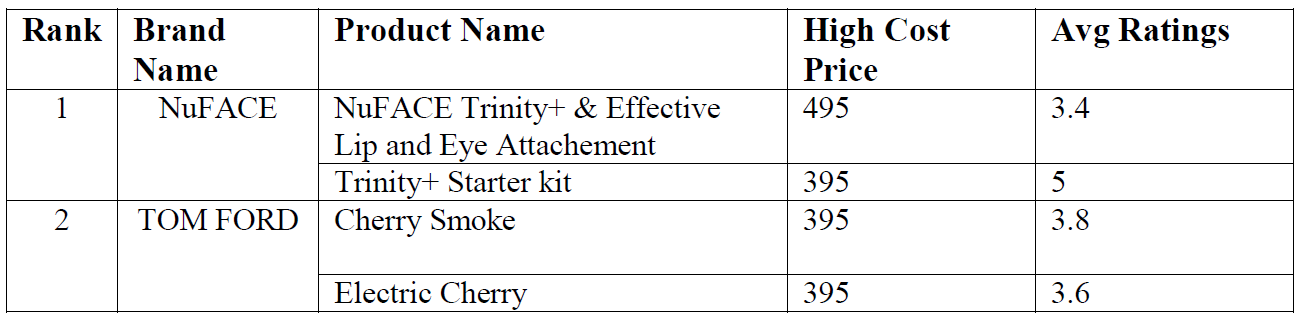



### ***6. Show visualization of total price shared by primary category***

In [ ]:
abc2=df_analys.groupby('primary_category')[['price_usd']].sum().to_dict()
#colors = ['gold', 'mediumturquoise', 'darkorange']
#plotting donut chart
fig = go.Figure(data=[go.Pie(text=list(abc2['price_usd'].keys()),labels=list(abc2['price_usd'].keys()),
                       values=list(abc2['price_usd'].values()),hole=.3)])
#Updating traces and layout to beautify the plot and setting the font size
fig.update_traces(textfont=dict(size=15,color='black'),marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title={'text': 'Total price shared by Primary category',
        'y':0.95,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'},paper_bgcolor='black',legend_title_font_color="White",title_font_color="White",font=dict(color="white"))
#show figure
fig.show()

**Observations:**

Among all primary categories, Skin care alone shares 33.5% with their price is 144499 USD and Fragrance share 28.6% with their price is 123643 USD.Then third position stands by Makeup which is 17.5%.

### Working with reviews dataset

In [10]:
rd1=pd.DataFrame(review_data1)
rd2=pd.DataFrame(review_data2)

review_df = pd.concat([rd1, rd2], axis=0)
review_df1 = review_df.dropna()

In [12]:
review_df.shape

(808855, 19)

In [ ]:
review_df.head(3)

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
5,5,42802569154,4,1.0,1.00,1,0,1,2023-03-19,The scent isn’t my favourite but it works grea...,Great!,lightMedium,brown,normal,brown,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
6,6,6941883808,2,0.0,0.25,8,6,2,2023-03-19,I’ll give this 2 stars for nice packaging and ...,Dried my lips out and clogged my pores,light,blue,combination,brown,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
8,8,7656791726,5,1.0,1.00,1,0,1,2023-03-18,I love this stuff. I first had the sample size...,Must have.,light,blue,normal,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


### ***7.Which product is most recommended by user and its skin tone?***

In [ ]:
is_rec=review_df.groupby(['product_name','skin_tone'])['is_recommended'].sum().reset_index().sort_values(by='is_recommended',ascending=False).head(15)

In [ ]:
fig = px.bar(x='product_name',y='is_recommended',data_frame=is_rec,color='skin_tone',text='is_recommended',barmode='group',opacity=.7,pattern_shape="skin_tone",
             pattern_shape_sequence=['x', '/', '\\'],color_discrete_sequence=px.colors.qualitative.Set1)
#Updating traces and layout to beautify the plot and setting the font size
fig.update_layout(title={'text': 'Product most recommended by customer respective to its skin tone',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},yaxis_title='Recommendation Count',xaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12)),yaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12),
        showgrid=False,
        showticklabels=True),plot_bgcolor='black',autosize=False,
    width=1200,
    height=600)
#show figure
fig.show()

**Observations:**

* Based on "Light" Skin Tone, Lip Sleeping Mask Intense Hydration with Vitamin C products stands top among other products with count of 826 user recommendation

* Based on "Fair" Skin Tone, Lip Sleeping Mask Intense Hydration with Vitamin C products stands top among other products with count of 666 user recommendation


### ***8. Analyse the Positive feedback count for each brand and other features***

In [ ]:
is_rec1=review_df.groupby(['brand_name','skin_type','eye_color','hair_color'])['total_feedback_count','total_pos_feedback_count','total_neg_feedback_count'].sum().reset_index().sort_values(by='total_feedback_count',ascending=False).head(15)


In [ ]:
fig = px.sunburst(is_rec1, path=['brand_name','skin_type','eye_color','hair_color'], values='total_pos_feedback_count')
fig.update_layout(title={'text': 'Total Positive feedback for Brand Name, Skin,Eye and Hair features',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},autosize=False,yaxis=dict(
        showgrid=False),xaxis=dict(
        showgrid=False),
    width=1400,
    height=600,paper_bgcolor="black",title_font_color="White")
fig.show()

**Observations:**

The above plot is described in table for quick insights

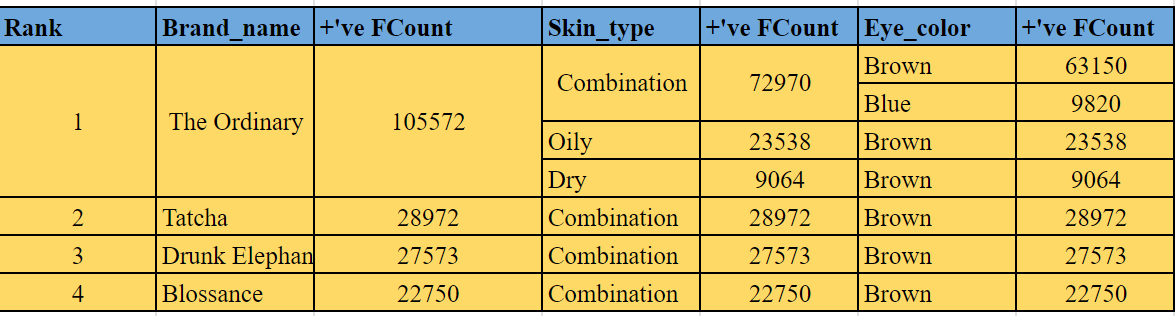

### ***9. Number of ratings given on Each date***

In [ ]:
review_df['submission_time'] = pd.to_datetime(review_df['submission_time'])


In [ ]:
dt=review_df.groupby('submission_time')['rating'].count().reset_index()

In [ ]:
fig = px.line(dt, x='submission_time', y="rating",labels={'rating':'Total Rating count'})
fig.update_layout(title={'text': "Number of ratings Submitted on Each Date",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},xaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12)),yaxis=dict(titlefont = dict(size=14),tickfont = dict(size=12),
        showgrid=True,
        showticklabels=True),plot_bgcolor='black',autosize=False,
    width=1200,
    height=600)
fig.show()

**Observations:**

* In the year of 2020 the number ratings is high and peak during that period
* The year between 2018 to 2020, the average rating is between 50-100